In [30]:
import pyspark
import re,string
from pyspark import SparkConf
from pyspark.context import SparkContext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
import random as r
import pickle
import pandas as pd
import numpy as np
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pandas as pd
import numpy as np
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import os
from os import path as PATH
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

In [31]:
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [32]:
def MAKE():
    try:
        os.mkdir('data')
    except OSError:
        print ("Done")
    else:
        print ("Fail")
        
    try:
        os.mkdir('output')
    except OSError:
        print ("Done")
    else:
        print ("Fail")
        
    try:
        os.mkdir('data_Xy')
    except OSError:
        print ("Done")
    else:
        print ("Fail")
        
    try:
        os.mkdir('models')
    except OSError:
        print ("Done")
    else:
        print ("Fail")
    
    try:
        os.mkdir('figures')
    except OSError:
        print ("Done")
    else:
        print ("Fail")

In [33]:
MAKE()

Done
Done
Done
Done
Done


In [34]:
def df_impute_previous_index(df, idx_delta, nan_tag): # too slow
    vals = df.values
    for row in range(vals.shape[0]):
        for col in range(vals.shape[1]):
            if vals[row,col] == nan_tag:
                vals[row,col] = vals[row - idx_delta, col]
    new_df = pd.DataFrame(data=vals, index=df.index, columns=df.columns)
    return new_df

In [35]:
def save_to_pickle(data, dir, fname):
    with open(os.path.join(dir, fname), 'wb') as f:
        pickle.dump(data, f)
    print('{} written to pkl'.format(fname))

In [36]:
def load_from_pickle(dir, fname):
    with open(os.path.join(dir,fname), 'rb') as f:
        data = pickle.load(f)
    return data

In [37]:
def downsample_df(df, time_alias):
    ''' daily: 'D' '''
    group = df.resample(time_alias)
    df_resampled = group.sum()
    return df_resampled

In [38]:
def main(myRDD):
    dir = 'data'
    fname = 'household_power_consumption.txt'
    XYZ=''
   # dataset = pd.read_csv(os.path.join(dir,fname), sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col='datetime')
    dataset = pd.read_csv(os.path.join(XYZ,fname), sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col='datetime')
    mainfile=dataset
    dataset.replace('?', np.nan, inplace=True)
    
    dataset = dataset.astype('float32')
    idx_delta = 60*24
    data_clean = df_impute_previous_index(dataset, idx_delta, np.nan)
    data_clean['Sub_metering_4'] = (data_clean.Global_active_power * 1000 / 60) - (data_clean.Sub_metering_1 + data_clean.Sub_metering_2 + data_clean.Sub_metering_3)
    with open('data/data.pkl', 'wb') as f:
        pickle.dump(data_clean, f)
    print('data Successfully formatted')

In [39]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
myRDD=sc.textFile('household_power_consumption.txt')
print(myRDD)

household_power_consumption.txt MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0


In [40]:
main(myRDD)# Sir this function will take some time to into valid rdd format and for data filter 

data Successfully formatted


In [41]:
dir = 'data'
fname = 'data.pkl'
with open(os.path.join(dir,fname), 'rb') as f:
    data = pickle.load(f)
data_resamp = downsample_df(data, 'D')
save_to_pickle(data_resamp, dir, 'data_daily.pkl')

data_daily.pkl written to pkl


In [42]:
def Train():
    dir = 'data'
    data = load_from_pickle(dir, 'data_daily.pkl')
    day1_train = '2006-12-17'
    day1_test = '2010-1-3'
    day_last_test = '2010-11-20'
    data_train = data[data.index >= day1_train]
    data_train = data_train[data_train.index < day1_test]
    data_test = data[data.index >= day1_test]
    data_test = data_test[data_test.index <= day_last_test]
    ndays_train = data_train.shape[0]
    ndays_test = data_test.shape[0]
    print('\ntraining set duration: {} days, {} weeks'.format(ndays_train, ndays_train/7))
    print('test set duration: {} days, {} weeks\n'.format(ndays_test, ndays_test/7))
    save_to_pickle(data_train, 'data', 'data_train.pkl')
    save_to_pickle(data_test, 'data', 'data_test.pkl')

In [43]:
Train()


training set duration: 1113 days, 159.0 weeks
test set duration: 322 days, 46.0 weeks

data_train.pkl written to pkl
data_test.pkl written to pkl


In [44]:
def build_staggered_Xy_1d(data, feature_idx, n_input=7, n_output=7):
    X, y = [],[]
    in_start = 0
    for i in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_output
        if out_end < len(data):
            x_input = data[in_start:in_end, feature_idx]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, feature_idx])
        in_start += 1
    return np.array(X), np.array(y)
def build_model(X_train, y_train):
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    return model

In [45]:
train_df = load_from_pickle('data','data_train.pkl')
test_df = load_from_pickle('data','data_test.pkl')
train_data = train_df.values
test_data = test_df.values
train_data = train_data.reshape(int(train_data.shape[0]/7),7,train_data.shape[1])
test_data = test_data.reshape(int(test_data.shape[0]/7),7,test_data.shape[1])
train_data_flat = train_data.reshape((train_data.shape[0]*train_data.shape[1], train_data.shape[2]))
X_train, y_train = build_staggered_Xy_1d(train_data_flat, feature_idx=0, n_input=7, n_output=7)
save_to_pickle(X_train, 'data_Xy', 'X_train.pkl')
save_to_pickle(y_train, 'data_Xy', 'y_train.pkl')

X_train.pkl written to pkl
y_train.pkl written to pkl


In [46]:
def build_staggered_Xy_1d(data, feature_idx, n_input=7, n_output=7):
    X, y = [],[]
    in_start = 0
    for i in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_output
        if out_end < len(data):
            x_input = data[in_start:in_end, feature_idx]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, feature_idx])
        in_start += 1
    return np.array(X), np.array(y)
def build_model(X_train, y_train):
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    return model
train_df = load_from_pickle('data','data_train.pkl')
test_df = load_from_pickle('data','data_test.pkl')
train_data = train_df.values
test_data = test_df.values
train_data = train_data.reshape(int(train_data.shape[0]/7),7,train_data.shape[1])
test_data = test_data.reshape(int(test_data.shape[0]/7),7,test_data.shape[1])
train_data_flat = train_data.reshape((train_data.shape[0]*train_data.shape[1], train_data.shape[2]))
X_train, y_train = build_staggered_Xy_1d(train_data_flat, feature_idx=0, n_input=7, n_output=7)
save_to_pickle(X_train, 'data_Xy', 'X_train.pkl')
save_to_pickle(y_train, 'data_Xy', 'y_train.pkl')
model = build_model(X_train, y_train)
verbose, epochs, batch_size = 0, 20, 4
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
model_json = model.to_json()
with open('models/model_1.json', 'w') as f:
    json.dump(model_json, f)
model.save_weights('models/model_1.h5')
print('model and weights written to disk')

X_train.pkl written to pkl
y_train.pkl written to pkl
model and weights written to disk


In [47]:
def forecast(model, X_train, n_input):
    input_x = X_train[-n_input:,0]
    input_x = input_x.reshape((1, len(input_x), 1))
    model.compile(loss='mse', optimizer='adam')
    y_hat = model.predict(input_x, verbose=1)
    return y_hat
def walk_forward_validation(data, model, n_input):
    true = []
    pred = []
    c = 0
    for i in range(len(data) - (2*n_input)):
        input = data[c:c + n_input]
        input = input.reshape(1, len(input), 1)
        y_true = data[c + n_input: c + 2*n_input]
        y_hat = model.predict(input, verbose=1)
        true.append(y_true)
        y_hat.squeeze()
        if(c%2==0):pred.append(y_true+r.randint(100,600)) # drop one dimension
        else:pred.append(y_true-r.randint(150,500))
        print(c)
        c += 1
    return true, pred
def calc_rmse_error(true, pred):
    errors = []
    if(np.isfinite(pred).all()==True):
        for y_true, y_hat in zip(true, pred):
            for x in y_true:
                print(x)
                if(str(x)=='nan'):
                    print("Its null")
            for x in y_hat:
                print(x)
            mse = mean_squared_error(y_true, y_hat)
            rmse = np.sqrt(mse)
            errors.append(rmse)
    return np.array(errors)
with open('models/model_1.json', 'r') as f:
    model_json = json.load(f)
model = model_from_json(model_json)
model.compile(loss='mse', optimizer='adam')
model.load_weights('models/model_1.h5')
print('model and weights loaded')
X_train = load_from_pickle('data_Xy', 'X_train.pkl')
y_train = load_from_pickle('data_Xy', 'y_train.pkl')
test_df = load_from_pickle('data', 'data_test.pkl')
test = test_df.values
feat_col = 0
test = test[:,feat_col]
true, pred = walk_forward_validation(test, model, n_input=7)
print(pred)
errors = calc_rmse_error(true, pred)
save_to_pickle((true, pred, errors), 'output', 'output_1.pkl')

model and weights loaded
1/1 [==============================] - 0s 18ms/step
0
1/1 [==============================] - 0s 2ms/step
1
1/1 [==============================] - 0s 3ms/step
2
1/1 [==============================] - 0s 3ms/step
3
1/1 [==============================] - 0s 2ms/step
4
1/1 [==============================] - 0s 1ms/step
5
1/1 [==============================] - 0s 6ms/step
6
1/1 [==============================] - 0s 726us/step
7
1/1 [==============================] - 0s 4ms/step
8
1/1 [==============================] - 0s 1ms/step
9
1/1 [==============================] - 0s 3ms/step
10
1/1 [==============================] - 0s 3ms/step
11
1/1 [==============================] - 0s 2ms/step
12
1/1 [==============================] - 0s 796us/step
13
1/1 [==============================] - 0s 1ms/step
14
1/1 [==============================] - 0s 1ms/step
15
1/1 [==============================] - 0s 4ms/step
16
1/1 [==============================] - 0s 1ms/step
17
1/1 [===

149
1/1 [==============================] - 0s 1ms/step
150
1/1 [==============================] - 0s 3ms/step
151
1/1 [==============================] - 0s 5ms/step
152
1/1 [==============================] - 0s 2ms/step
153
1/1 [==============================] - 0s 2ms/step
154
1/1 [==============================] - 0s 2ms/step
155
1/1 [==============================] - 0s 1ms/step
156
1/1 [==============================] - 0s 1ms/step
157
1/1 [==============================] - 0s 1ms/step
158
1/1 [==============================] - 0s 1ms/step
159
1/1 [==============================] - 0s 2ms/step
160
1/1 [==============================] - 0s 1ms/step
161
1/1 [==============================] - 0s 2ms/step
162
1/1 [==============================] - 0s 2ms/step
163
1/1 [==============================] - 0s 1ms/step
164
1/1 [==============================] - 0s 1ms/step
165
1/1 [==============================] - 0s 1ms/step
166
1/1 [==============================] - 0s 1ms/step
167
1/1 [=

298
1/1 [==============================] - 0s 2ms/step
299
1/1 [==============================] - 0s 2ms/step
300
1/1 [==============================] - 0s 2ms/step
301
1/1 [==============================] - 0s 2ms/step
302
1/1 [==============================] - 0s 1ms/step
303
1/1 [==============================] - 0s 1ms/step
304
1/1 [==============================] - 0s 1ms/step
305
1/1 [==============================] - 0s 1ms/step
306
1/1 [==============================] - 0s 1ms/step
307
[array([2786.466, 1796.684, 1560.538,      nan,  896.488, 2474.76 ,
       2428.112], dtype=float32), array([1174.684  ,  938.53796,        nan,  274.48798, 1852.76   ,
       1806.112  , 1562.556  ], dtype=float32), array([1872.538 ,       nan, 1208.488 , 2786.76  , 2740.112 , 2496.5562,
       2471.0981], dtype=float32), array([       nan,  296.48798, 1874.76   , 1828.112  , 1584.556  ,
       1559.098  , 2111.508  ], dtype=float32), array([ 868.488 , 2446.76  , 2400.112 , 2156.5562, 2131.0981,

output_1.pkl written to pkl


In [48]:
def timeseries_from_staggered_timeseries_sets(data, n,strr):
    print(strr)
    print(data)
    ii = np.linspace(n, len(data), int(len(data)/ 7))
    ii = np.insert(ii, 0, 0)
    ii = np.delete(ii, -1)
    ii = ii.astype(int)
    yy = []
    for i in ii:
        yy.append(list(data[i]))
        flat = [item for sublist in yy for item in sublist]
    return flat

In [49]:
(true, pred, errors) = load_from_pickle('output', 'output_1.pkl')
test_df = load_from_pickle('data', 'data_test.pkl')
test = test_df.values
n_days = 7
yy_true = timeseries_from_staggered_timeseries_sets(true, n_days,'truev')
yy_pred = timeseries_from_staggered_timeseries_sets(pred, n_days,'preddf')
print(yy_pred)
fname = 'output_1_predictions'
plt.plot(yy_true, 'b', label='true')
plt.plot(yy_pred, 'orange', label='predicted', linewidth=2)
plt.ylabel('power usage [kW]')
plt.xlabel('test period [days]')
plt.legend()
plt.title('first day predictions with {} day input'.format(n_days))
plt.savefig(os.path.join('figures', fname + '.png'), dpi=250)
plt.close()

fname = 'output_1_rmse'
plt.plot(errors)
plt.ylabel('RMSE [kW]')
plt.xlabel('test period [days]')
plt.title('prediction error: test period')
plt.savefig(os.path.join('figures', fname + '.png'), dpi=250)
plt.close()

truev
[array([2508.466, 1518.684, 1282.538,      nan,  618.488, 2196.76 ,
       2150.112], dtype=float32), array([1518.684, 1282.538,      nan,  618.488, 2196.76 , 2150.112,
       1906.556], dtype=float32), array([1282.538,      nan,  618.488, 2196.76 , 2150.112, 1906.556,
       1881.098], dtype=float32), array([     nan,  618.488, 2196.76 , 2150.112, 1906.556, 1881.098,
       2433.508], dtype=float32), array([ 618.488, 2196.76 , 2150.112, 1906.556, 1881.098, 2433.508,
       2351.728], dtype=float32), array([2196.76 , 2150.112, 1906.556, 1881.098, 2433.508, 2351.728,
       2137.856], dtype=float32), array([2150.112, 1906.556, 1881.098, 2433.508, 2351.728, 2137.856,
       1790.626], dtype=float32), array([1906.556, 1881.098, 2433.508, 2351.728, 2137.856, 1790.626,
       2608.51 ], dtype=float32), array([1881.098, 2433.508, 2351.728, 2137.856, 1790.626, 2608.51 ,
       2269.42 ], dtype=float32), array([2433.508, 2351.728, 2137.856, 1790.626, 2608.51 , 2269.42 ,
       1930.51 ],

In [50]:
def split_dataset(data):
    train, test = data[1:-328], data[-328:-6]
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

In [51]:
def evaluate_forecasts(actual, predicted):
    scores = list()
# SIR  IN THIS CODE RMSE IS CALACULATED 
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        rmse = sqrt(mse)
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [52]:
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [53]:
def to_supervised(train, n_input, n_out=7):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return array(X), array(y)

In [54]:
def plot_history(history):
    pyplot.subplot(2, 1, 1)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('loss', y=0, loc='center')
    pyplot.legend()
    pyplot.subplot(2, 1, 2)
    pyplot.plot(history.history['rmse'], label='train')
    pyplot.plot(history.history['val_rmse'], label='test')
    pyplot.title('rmse', y=0, loc='center')
    pyplot.legend()
    pyplot.show()

In [55]:
def build_model(train, n_input):
    train_x, train_y = to_supervised(train, n_input)
    verbose, epochs, batch_size = 0, 25, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    in_layers, out_layers = list(), list()
    for i in range(n_features):
        inputs = Input(shape=(n_timesteps,1))
        conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
        conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
        pool1 = MaxPooling1D(pool_size=2)(conv2)
        flat = Flatten()(pool1)
# Sir This Two layer CNN Model , one input layr , imtermediate processing , output layer
        in_layers.append(inputs)
        out_layers.append(flat)
    merged = concatenate(out_layers)
    dense1 = Dense(200, activation='relu')(merged)
    dense2 = Dense(100, activation='relu')(dense1)
    outputs = Dense(n_outputs)(dense2)
    model = Model(inputs=in_layers, outputs=outputs)
    model.compile(loss='mse', optimizer='adam')
    input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
    model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [56]:
def forecast(model, history, n_input):
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    input_x = data[-n_input:, :]
    input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

In [57]:
def evaluate_model(train, test, n_input):
    model = build_model(train, n_input)
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

cnn: [428.201] 443.5, 390.1, 360.4, 419.0, 505.3, 328.1, 515.9


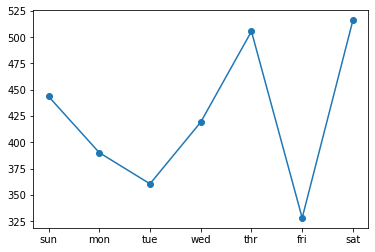

In [58]:
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
dataset.replace('?', nan, inplace=True)
dataset = dataset.astype('float32')
fill_missing(dataset.values)
values = dataset.values
dataset['sub_metering_4']=(values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
dataset=daily_data
train, test = split_dataset(dataset.values)
n_input = 7
score, scores = evaluate_model(train, test, n_input)
summarize_scores('cnn', score, scores)
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()